In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np
from scipy.spatial import ConvexHull

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Rectangle, Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, DivergingNorm, to_rgba

# Atoms
from ase.io import read
from ase.visualize.plot import plot_atoms

# ML
from kernels import sqeuclidean_distances

# Utilities
import h5py
import json
import project_utils as utils
import gzip
from copy import deepcopy

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Functions

In [2]:
# Compute the hull distances
def hull_distances(vprobprune, energies, projections, n_dim):
    gch_vertices = np.nonzero(vprobprune[-1])[0]
    
    vertices = np.zeros(projections.shape[0], dtype=int)
    vertices[gch_vertices] = 1
    
    energies_gch = energies[gch_vertices]
    projections_gch = projections[gch_vertices]
    
    ep = np.hstack((energies[:, np.newaxis], projections))
    ep_gch = np.hstack((energies_gch[:, np.newaxis], projections_gch))
    
    vertex_hull = ConvexHull(ep_gch[:, 0:n_dim])
    
    # Omit the simplices on the 'top' of the GCH
    vertex_hull_facets = np.delete(
        vertex_hull.equations,
        np.nonzero(vertex_hull.equations[:, 0] > 0.0),
        axis=0
    )
    
    hull_distance = -1.0 * (
        np.matmul(ep[:, 0:n_dim], vertex_hull_facets[:, 0:-1].T) 
        + vertex_hull_facets[:, -1]
    )
    
    hull_distance_energy = -1.0 * hull_distance / vertex_hull_facets[:, 0]
    
    hull_distance = np.amin(np.abs(hull_distance), axis=1)
    hull_distance_energy = np.amin(np.abs(hull_distance_energy), axis=1)
    
    return hull_distance, hull_distance_energy

# Load Data

In [6]:
model_dir = '../../Processed_Data/Models'

deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'
gch_dir = f'{model_dir}/{cutoff}/GCH/4-Class/{spectrum_name}/{group_name}'

In [7]:
cutoff = 6.0
spectrum = 'power'
spectrum_name = spectrum.capitalize()
group_name = 'OO+OSi+SiSi'
mixing_suffixes = ['', '_0.0', '_1.0']

In [8]:
# Atomic structures
frames = read(f'{gch_dir}/iza+deem.xyz', index=':')

## Test and train sets

In [9]:
# Load train and test indices
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_test.idxs', dtype=int)

iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)
iza_sort_test_idxs = np.argsort(iza_test_idxs)
iza_unsort_test_idxs = np.argsort(iza_sort_test_idxs)

In [10]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)[iza_test_idxs]
iza_codes = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=0, dtype=str)[iza_test_idxs]
n_iza = len(iza_codes)

deem_cantons_2 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)[deem_test_idxs]
deem_cantons_4 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)[deem_test_idxs]
deem_codes = np.arange(0, 331172) + 8000001
deem_codes = deem_codes[deem_test_idxs]
n_deem = len(deem_codes)

## Properties

In [11]:
# Si fractions
Si_fraction_iza = np.loadtxt('../../Raw_Data/IZA_230/compositions.dat', usecols=1)[iza_test_idxs]
Si_fraction_deem = np.ones(n_deem) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))

In [12]:
# Structure energies
deem_330k_energies = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_energies.dat')[deem_test_idxs]
iza_energies = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_energies.dat')[iza_test_idxs]
energies = np.concatenate((iza_energies, deem_330k_energies))

In [13]:
# Structure volumes
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_volumes.dat')[deem_test_idxs]
iza_volumes = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_volumes.dat')[iza_test_idxs]
volumes = np.concatenate((iza_volumes, deem_330k_volumes))

In [14]:
# Decision functions
deem_330k_dfs_2 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[deem_test_idxs]
deem_330k_dfs_4 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[deem_test_idxs]

iza_dfs_2 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[iza_test_idxs]
iza_dfs_4 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[iza_test_idxs]

dfs_2 = np.concatenate((iza_dfs_2, deem_330k_dfs_2))
dfs_4 = np.concatenate((iza_dfs_4, deem_330k_dfs_4))

In [15]:
dfs = dfs_2

# GCH

In [16]:
# TODO: analysis for all GCH's (different PCovR mixing)

In [92]:
mixing = ''

In [93]:
# Hull distances (TODO: change this so we just save all the useful properties from the GCH notebook)
vprobprune = np.loadtxt(f'{gch_dir}/rattled{mixing}/vprobprune.dat')
T = np.loadtxt(f'{gch_dir}/T{mixing}.dat')
ndim = 3

d, de = hull_distances(vprobprune, energies, T, ndim)

In [94]:
gch_vertices = np.nonzero(vprobprune[-1])[0]
iza_vertices = gch_vertices[gch_vertices < n_iza]
deem_vertices = gch_vertices[gch_vertices >= n_iza]

vertices = np.zeros(T.shape[0], dtype=int)
vertices[gch_vertices] = 1

## Check rattled structures

In [95]:
T_rattled = np.loadtxt(f'{gch_dir}/rattled{mixing}/T{mixing}.dat')
ref_idxs = np.loadtxt(f'{gch_dir}/rattled{mixing}/refstruct.idx', dtype=int)

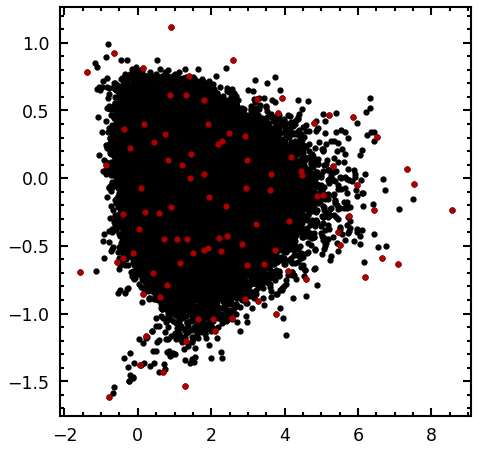

In [96]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T[ref_idxs, 0], T[ref_idxs, 1])
plt.show()

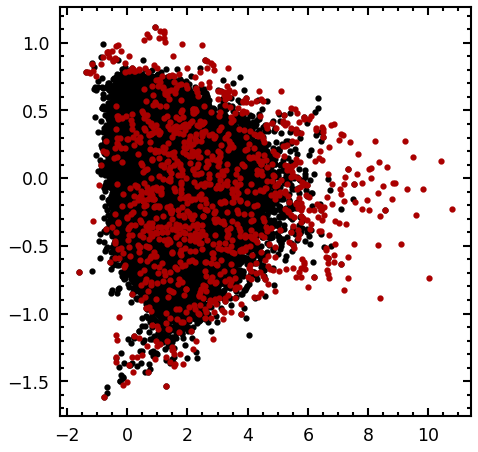

In [97]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T_rattled[:, 0], T_rattled[:, 1])
plt.show()

## Plot GCH

In [98]:
def histogram(X, Y, bins, return_edges=False):
    Z, X_edges, Y_edges = np.histogram2d(X, Y, bins=bins, density=True)
    dX = np.diff(X_edges)
    dY = np.diff(Y_edges)
    X_centers = X_edges[0:-1]
    Y_centers = Y_edges[0:-1]
    X_centers += dX / 2
    Y_centers += dY / 2
    X, Y = np.meshgrid(X_centers, Y_centers)
    
    if return_edges:
        return X, Y, Z.T, X_edges, Y_edges
    else:
        return X, Y, Z.T
    
def logbase(x, base):
    return np.log10(x) / np.log10(base)
    
def scale_points(data, min_value, max_value, inverted=False, log=False, base=10):
    normalized_data = (data - np.amin(data)) / (np.amax(data) - np.amin(data))
    if inverted:
        normalized_data = 1.0 - normalized_data
    
    if log:
        scaled_data = base ** (
            normalized_data * (
                logbase(max_value, base) - logbase(min_value, base)
            ) + logbase(min_value, base)
        )
    else:
        scaled_data =  normalized_data * (max_value - min_value) + min_value

    return scaled_data

In [99]:
frames_deem_vertices = [frames[idx] for idx in deem_vertices]
frames_iza_vertices = [frames[idx] for idx in iza_vertices]

In [100]:
base = 10
size_min = 1
size_max = 50
alpha_min = 0.01
alpha_max = 1.0
sizes = scale_points(de, size_min, size_max, inverted=True, log=True, base=base)
alphas = scale_points(de, alpha_min, alpha_max, inverted=True, log=True, base=base)

df_limits = np.abs([np.amin(dfs), np.amax(dfs)])
df_idx = np.argmin(df_limits)
df_limit = df_limits[df_idx]
if df_idx == 0:
    extend_key = 'max'
else:
    extend_key = 'min'
extend_key = 'neither'

# vmin = -df_limit
vmin = np.amin(dfs)
# vmax = df_limit
vmax = np.amax(dfs)

norm = DivergingNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
color_map = ScalarMappable(norm=norm, cmap='RdBu')
colors = color_map.to_rgba(dfs, alpha=1.0)
colors[:, -1] = alphas

ecolors = np.tile(to_rgba(color_list[0]), (len(colors), 1))
ecolors[:, -1] = alphas

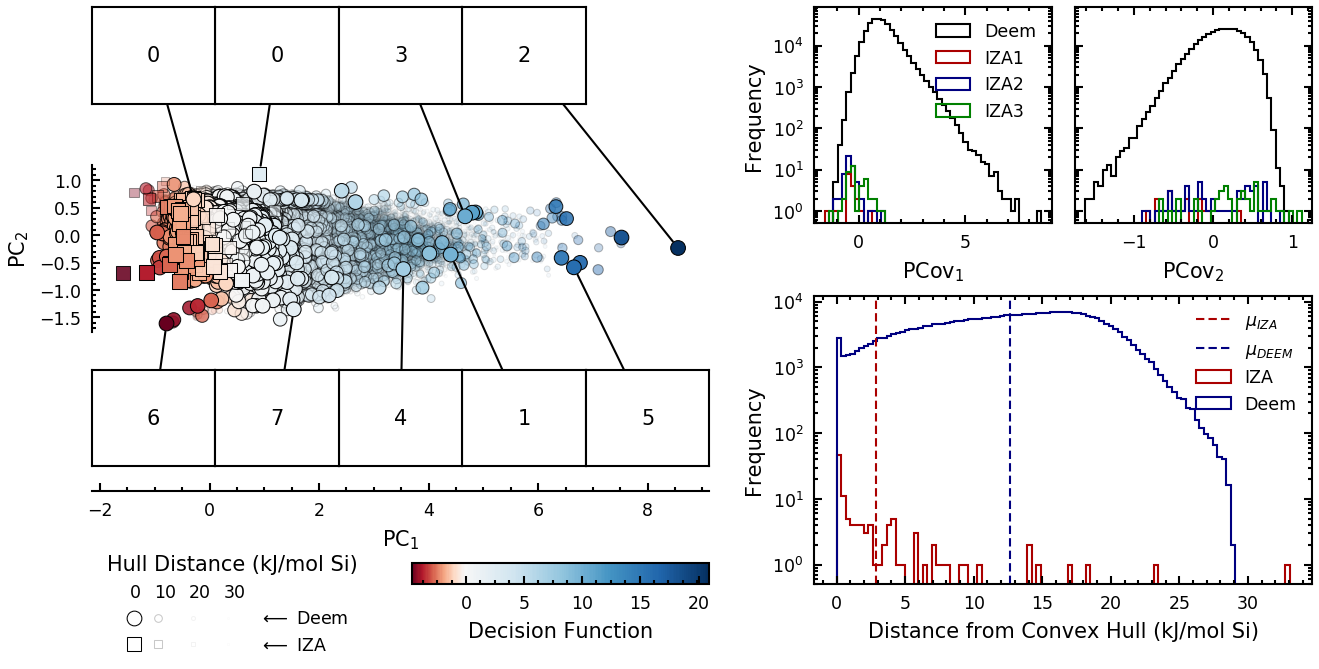

In [101]:
# TODO: highlight the 4 archetypes: IZA-like IZA, IZA-like Deem, Deem-like IZA, Deem-like Deem
fig = plt.figure(figsize=(10.5, 5.0))
gs = fig.add_gridspec(
    nrows=3, ncols=5,
    width_ratios=(1.0, 1.0, 0.20, 0.8, 0.8), height_ratios=(1.0, 0.90, 0.10),
    wspace=0.10, hspace=0.50
)

# GCH
axs = fig.add_subplot(gs[0:-1, 0:2])
axs.set_aspect(aspect='equal', anchor='W', adjustable='datalim')
axs_hull = fig.add_subplot(gs[1:, -2:])
caxs = fig.add_subplot(gs[-1, 1])
pcovr_axes = [fig.add_subplot(gs[0, i]) for i in range(-2, 0)]
pcovr_grouper = pcovr_axes[0].get_shared_y_axes()
for ax in pcovr_axes[1:]:
    pcovr_grouper.join(ax, pcovr_axes[0])
    ax.tick_params(labelleft=False)

T_iza = np.delete(T[0:n_iza], iza_vertices, axis=0)
de_iza = np.delete(de[0:n_iza], iza_vertices)
df_iza = np.delete(dfs[0:n_iza], iza_vertices)
s_iza = np.delete(sizes[0:n_iza], iza_vertices)
colors_iza = np.delete(colors[0:n_iza], iza_vertices, axis=0)
ecolors_iza = np.delete(ecolors[0:n_iza], iza_vertices, axis=0)
po_iza = np.flip(np.argsort(de_iza))

T_deem = np.delete(T[n_iza:], deem_vertices - n_iza, axis=0)
de_deem = np.delete(de[n_iza:], deem_vertices - n_iza)
df_deem = np.delete(dfs[n_iza:], deem_vertices - n_iza)
s_deem = np.delete(sizes[n_iza:], deem_vertices - n_iza)
colors_deem = np.delete(colors[n_iza:], deem_vertices - n_iza, axis=0)
ecolors_deem = np.delete(ecolors[n_iza:], deem_vertices - n_iza, axis=0)
po_deem = np.flip(np.argsort(de_deem))

T_iza_vertices = T[iza_vertices]
de_iza_vertices = de[iza_vertices]
df_iza_vertices = dfs[iza_vertices]
s_iza_vertices = sizes[iza_vertices]
colors_iza_vertices = colors[iza_vertices]
ecolors_iza_vertices = ecolors[iza_vertices]

T_deem_vertices = T[deem_vertices]
de_deem_vertices = de[deem_vertices]
df_deem_vertices = dfs[deem_vertices]
s_deem_vertices = sizes[deem_vertices]
colors_deem_vertices = colors[deem_vertices]
ecolors_deem_vertices = ecolors[deem_vertices]

# Deem
deem_pts = axs.scatter(
    T_deem[po_deem, 0], T_deem[po_deem, 1],
    c=colors_deem[po_deem],
    marker='o', edgecolor=ecolors_deem[po_deem], linewidth=0.5, s=s_deem[po_deem],
    rasterized=True
)
# IZA
iza_pts = axs.scatter(
    T_iza[po_iza, 0], T_iza[po_iza, 1],
    c=colors_iza[po_iza],
    marker='s', edgecolor=ecolors_iza[po_iza], linewidth=0.5, s=s_iza[po_iza],
    rasterized=True
)

# Deem vertices
axs.scatter(
    T_deem_vertices[:, 0], T_deem_vertices[:, 1],
    c=colors_deem_vertices,
    marker='o', edgecolor=ecolors_deem_vertices, linewidth=0.5, s=s_deem_vertices,
    zorder=3,
    rasterized=True
)

# IZA vertices
axs.scatter(
    T_iza_vertices[:, 0], T_iza_vertices[:, 1],
    c=colors_iza_vertices,
    marker='s', edgecolor=ecolors_iza_vertices, linewidth=0.5, s=s_iza_vertices,
    zorder=3,
    rasterized=True
)

cb = fig.colorbar(
    color_map, cax=caxs, label='Decision Function', orientation='horizontal', extend=extend_key
)

axs.set_xlabel(r'PC$_1$')
axs.set_ylabel(r'PC$_2$')

xcenter = 0.0
xlim = axs.get_xlim()
xticks = axs.get_xticks()
xticks_minor = axs.get_xticks(minor=True)
xticklabels = axs.get_xticklabels()

ycenter = 0.0
ylim = axs.get_ylim()
yticks = axs.get_yticks()
yticks_minor = axs.get_yticks(minor=True)
yticklabels = axs.get_yticklabels()

axs.set_xticks(xticks[1:-1]) # We seem to have extra major ticks at the limits
axs.set_xticks(xticks_minor, minor=True)

axs.set_yticks(yticks[1:-1]) # We seem to have extra major ticks at the limits
axs.set_yticks(yticks_minor, minor=True)

axs.spines['left'].set_bounds(*ylim)
axs.spines['bottom'].set_bounds(*xlim)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.tick_params(which='both', axis='both', top=False, right=False)

legend_distances = np.linspace(int(np.amin(de)), 10*int(np.amax(de) // 10), 4, dtype=int)
legend_sizes = scale_points(legend_distances, size_min, size_max, inverted=True, log=True, base=base)
legend_alphas = scale_points(legend_distances, alpha_min, alpha_max, inverted=True, log=True, base=base)

legend_patches = []
for legend_distance, legend_size, legend_alpha in zip(legend_distances, legend_sizes, legend_alphas):
    legend_patches.append(Line2D(
        [0], [0],
        linewidth=0.0,
        markersize=0.0,
        label=legend_distance
    ))
    for marker in ('o', 's'):
        legend_patches.append(Line2D(
            [0], [0],
            linewidth=0.0,
            marker=marker, markerfacecolor='w', 
            markeredgecolor=color_list[0], markeredgewidth=0.5,
            alpha=legend_alpha, markersize=np.sqrt(legend_size),
        ))

for label in ('', r'$\longleftarrow$ Deem', r'$\longleftarrow$ IZA'):
    legend_patches.append(Line2D([0], [0], linewidth=0.0, markersize=0.0, label=label))
    
legend = axs.legend(
    handles=legend_patches, 
    title='Hull Distance (kJ/mol Si)',
    loc='upper left', bbox_to_anchor=(0.0, -0.10),
    ncol=len(legend_patches) // 3,
    handletextpad=-1.25,
    columnspacing=0.0
)

#for legend_text in legend.get_texts()[1:-1:2]:
#    legend_text.set_visible(False)

#deem_inset_positions = [t + np.array([0.5, 0.5]) for t in T_deem_vertices[:, 0:2]]
deem_inset_positions = np.array([
    [0.0, 0.8],
    [0.6, 0.05],
    [0.6, 0.8],
    [0.4, 0.8],
    [0.4, 0.05],
    [0.8, 0.05],
    [0.0, 0.05],
    [0.2, 0.05]
])
iza_inset_positions = np.array([
    [0.2, 0.8],
])

#deem_inset_positions += T_deem_vertices[:, 0:2]
#deem_inset_positions = axs.transLimits.transform(deem_inset_positions)

#iza_inset_positions += T_iza_vertices[:, 0:2]
#iza_inset_positions = axs.transLimits.transform(iza_inset_positions)

inset_size = [0.2, 0.2]

for vertex_frames, color, vertices, inset_positions in zip(
    (frames_iza_vertices, frames_deem_vertices),
    (color_list[0], color_list[0]),
    (T_iza_vertices[:, 0:2], T_deem_vertices[:, 0:2]),
    (iza_inset_positions, deem_inset_positions)
):
    for vdx, (vertex, inset_position, frame) in enumerate(zip(vertices, inset_positions, vertex_frames)):
        axs_inset = axs.inset_axes([*inset_position, *inset_size])
        #plot_atoms(frame, axs_inset)
        axs_inset_center = np.array(inset_position) + np.array(inset_size) / 2
        
        axs.annotate(
            '',
            xy=vertex,
            xytext=axs_inset_center,
            xycoords=axs.transData,
            textcoords=axs.transAxes,
            arrowprops=dict(arrowstyle='-', color=color, shrinkB=4)
        )
        axs_inset.tick_params(
            which='both', axis='both', 
            left=False, bottom=False, right=False, top=False,
            labelleft=False, labelbottom=False, labelright=False, labeltop=False
        )
        
        axs_inset.text(
            0.5, 0.5,
            vdx,
            horizontalalignment='center', verticalalignment='center',
            transform=axs_inset.transAxes,
        )

# PCovR HISTOGRAMS
histogram_max = np.amax(T, axis=0)
histogram_min = np.amin(T, axis=0)
pcovr_histogram_parameters = dict(bins=50, density=False, log=True, histtype='step')

for pc, pcovr_axs in enumerate(pcovr_axes):
    histogram_range = (histogram_min[pc], histogram_max[pc])

    pcovr_axs.hist(
        T[n_iza:, pc], 
        range=histogram_range, 
        **pcovr_histogram_parameters, label='Deem'
    )
    
    for i in range(1, np.amax(iza_cantons)+1):
        canton_idxs = np.nonzero(iza_cantons == i)[0]
        
        pcovr_axs.hist(
            T[0:n_iza, pc][canton_idxs], 
            range=histogram_range, 
            **pcovr_histogram_parameters, label=f'IZA{i}'
        )
            
    if pc == 0:
        pcovr_axs.set_ylabel('Frequency')
        
    pcovr_axs.set_xlabel(fr'PCov$_{{{pc+1}}}$')
    pcovr_axs.set_ylim((0.5, pcovr_axs.get_ylim()[1]))

pcovr_axes[0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# HULL HISTOGRAM
# TODO: how to make the scale the same as the energies in the PCA plot, since those include RWY?
hull_histogram_parameters = dict(
    range=(np.amin(de), np.amax(de)),
    density=False, bins=100, log=True,
)

axs_hull.hist(
    de[0:n_iza], **hull_histogram_parameters, 
    color=color_list[1], histtype='step', label='IZA'
)
axs_hull.axvline(
    np.mean(de[0:n_iza]), 
    color=color_list[1], linestyle='--', label=r'$\mu_{IZA}$'
)

axs_hull.hist(
    de[n_iza:], 
    **hull_histogram_parameters, 
    color=color_list[2], histtype='step', label='Deem'
)
axs_hull.axvline(
    np.mean(de[n_iza:]), 
    color=color_list[2], linestyle='--', label=r'$\mu_{DEEM}$'
)

axs_hull.set_ylabel('Frequency')
axs_hull.set_xlabel('Distance from Convex Hull (kJ/mol Si)')
axs_hull.set_ylim((0.5, axs_hull.get_ylim()[1]))

axs_hull.legend()

#fig.savefig(f'../../Results/{cutoff}/gch_{cutoff}_{spectrum}_{group_name}{mixing}.pdf', bbox_inches='tight')

plt.show()

# Hull stats

In [102]:
print(np.argmax(de), np.amax(de))

33 33.05825273674645


In [28]:
iza_de = np.argsort(de)
iza_de = iza_de[iza_de < n_iza]
for d, code, canton in zip(
    de[iza_de], 
    iza_codes[iza_de], 
    iza_cantons[iza_de]
):
    print(f'{code}\t{canton}\t{d}')

BSV	3	0.0
YFI	2	0.00555958151534579
TER	2	0.011413306826323213
TON	2	0.011534258867666618
AVE	3	0.01557739508397541
AFI	3	0.017906288097938143
PTT	2	0.03336686929723158
MRT	2	0.03551830499968382
APD	3	0.04270914625810485
IHW	1	0.04465105717273996
SAF	3	0.046252021662368865
ATT	3	0.05149362231904851
MEP	1	0.06766473282830378
VET	1	0.07418358531164228
SIV	3	0.07723648600469009
MSE	2	0.09918637086722443
MEL	2	0.10395599334227187
SGT	1	0.10526660661086115
ITE	1	0.11971296014874806
AEI	3	0.12382106732027605
DDR	1	0.1286108458389427
RTH	2	0.13057056138226747
BOG	2	0.1339917848154966
ATV	3	0.14032711923924268
PHI	2	0.14318421520507724
MSO	2	0.15074119302707195
LEV	2	0.1613795994381726
MWF	2	0.16403243922256125
SZR	2	0.16993777178463682
BRE	2	0.18288149910776771
SFG	2	0.22011229787841446
BOF	3	0.2260700840938749
SVV	2	0.2267947305838228
IFW	2	0.23774363544955782
PSI	3	0.24476307012859444
MTT	2	0.24756641378441577
GIS	2	0.24761933034303094
MTW	2	0.2635356163702158
AWW	3	0.26478216518808206
NSI	

In [29]:
canton_1_idxs = np.nonzero(iza_cantons == 1)[0]
iza_de = np.argsort(de[canton_1_idxs])
for d, code, canton in zip(
    de[canton_1_idxs][iza_de], iza_codes[canton_1_idxs][iza_de], iza_cantons[canton_1_idxs][iza_de]
):
    print(f'{code}\t{canton}\t{d}')

IHW	1	0.04465105717273996
MEP	1	0.06766473282830378
VET	1	0.07418358531164228
SGT	1	0.10526660661086115
ITE	1	0.11971296014874806
DDR	1	0.1286108458389427
NSI	1	0.2654495697783202
PCR	1	0.36185257074202676
ITH	1	0.37827600131551403
NON	1	0.533209126151666
MTN	1	0.9149640945239866
STF	1	1.0450411617983546
CFI	1	1.064332252591721
RRO	1	1.5118414912794904
LTF	1	1.7148582422928356
OKO	1	2.051540119451215
IFR	1	2.5847563143614303
CSV	1	2.668754284212646


In [30]:
de_limit = de[canton_1_idxs][iza_de][-1]
print(de_limit)

2.668754284212646


## SVM-based candidates

In [31]:
def k_nearest_neighbors(A, B, y, k=1):
    """
        Computes the property y' for dataset A
        based on the average of properties y of 
        the k closest instances of dataset B 
        (Euclidean distance)
        
        ---Arguments---
        A: dataset with unknown properties
        B: "reference" dataset with known properties
        y: known properties of dataset B
        k: number of nearest neighbors
        
        ---Returns---
        yy: k-nearest-neighbor properties for dataset A
    """
    
    if A.ndim == 1:
        A = np.reshape(A, (-1, 1))
    if B.ndim == 1:
        B = np.reshape(B, (1, -1))
        
    D = np.sqrt(sqeuclidean_distances(A, B))
    idxs = np.argsort(D, axis=1)[:, 0:k]
    yy = np.mean(y[idxs], axis=1)
    return yy

In [32]:
most_iza_deem_idxs = np.argsort(deem_330k_dfs_2)
most_iza_iza_idxs = np.argsort(iza_dfs_2)

In [33]:
n_select = 5

In [34]:
# Most IZA-like Deem
most_iza_idxs = most_iza_deem_idxs[0:n_select]
most_iza_soap_idxs = deem_codes[most_iza_idxs] - 8000001
most_iza_sort_idxs = np.argsort(most_iza_soap_idxs)
most_iza_unsort_idxs = np.argsort(most_iza_sort_idxs)

print(deem_codes[most_iza_idxs])
print(deem_330k_dfs_2[most_iza_idxs])
print(Si_fraction_deem[most_iza_idxs])

# Load SOAPs
deem_soaps = utils.load_hdf5(
    f'{deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=most_iza_soap_idxs[most_iza_sort_idxs]
)[most_iza_unsort_idxs]

iza_soaps = utils.load_hdf5(
    f'{iza_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=iza_test_idxs[iza_sort_test_idxs]
)[iza_unsort_test_idxs]

predicted_Si_fraction = k_nearest_neighbors(deem_soaps, iza_soaps, Si_fraction_iza, k=1)
print(predicted_Si_fraction.squeeze())

[8283748 8162065 8204697 8162069 8054476]
[-4.57260927 -4.24186819 -4.10678037 -3.89826663 -3.55224275]
[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
[0.33333 0.33333 0.33333 0.33333 0.     ]


In [35]:
# Most Deem-like Deem
most_deem_idxs = most_iza_deem_idxs[-n_select:]
print(deem_codes[most_deem_idxs])
print(deem_330k_dfs_2[most_deem_idxs])
print(Si_fraction_deem[most_deem_idxs])

[8229490 8187831 8054203 8126142 8129504]
[17.26236124 17.33338884 17.97300412 18.20192276 20.91711481]
[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]


In [36]:
# Most IZA-like IZA
most_iza_idxs = most_iza_iza_idxs[0:n_select]
print(iza_codes[most_iza_idxs])
print(iza_dfs_2[most_iza_idxs])
print(Si_fraction_iza[most_iza_idxs])

['MTN' 'SBN' 'MEP' 'NAT' 'VSV']
[-4.60840191 -4.20661498 -3.60998424 -3.35044084 -3.28654155]
[0.33333 0.      0.33333 0.2     0.25926]


In [37]:
# Most Deem-like IZA
most_deem_idxs = most_iza_iza_idxs[-n_select:]
print(iza_codes[most_deem_idxs])
print(iza_dfs_2[most_deem_idxs])
print(Si_fraction_iza[most_deem_idxs])

['APC' 'SOS' 'BCT' 'BSV' 'CZP']
[1.1724671  1.39054576 1.93543046 2.36617566 2.60680398]
[0.      0.      0.23833 0.      0.     ]


## GCH-based candidates

In [49]:
gch_vertices_de = np.nonzero(de <= de_limit)[0]
iza_vertices_de = gch_vertices_de[gch_vertices_de < n_iza]
deem_vertices_de = gch_vertices_de[gch_vertices_de >= n_iza]

In [50]:
# Vertex structures
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
1
['BSV']
=== Deem candidates ===
8
[8116170 8129309 8129504 8147992 8154453 8171811 8283748 8301974]


In [51]:
# Structures within de_limit of hull
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
62
['TER' 'SVV' 'GIS' 'ATV' 'MSE' 'MRT' 'NSI' 'AFX' 'YFI' 'SGT' 'ITH' 'BSV'
 'MTT' 'AWO' 'IHW' 'APD' 'PTT' 'PHI' 'EUO' 'AWW' 'PWN' 'RUT' 'SAV' 'RTH'
 'MSO' 'PCR' 'BOF' 'PSI' 'AFI' 'SEW' 'MEP' 'TON' 'SZR' 'AEN' 'MTW' 'DFT'
 'SIV' 'PWW' 'SFG' 'ITG' 'AVE' 'MEL' 'AEI' 'VET' 'MFS' 'NON' 'GIU' 'BRE'
 'ITE' 'BOG' 'MTN' 'SAF' 'LOS' 'EWO' 'IFW' 'DDR' 'LEV' 'KFI' 'FRA' 'LAU'
 'MWF' 'ATT']
=== Deem candidates ===
5868
[8000060 8000118 8000234 ... 8331061 8331070 8331093]


In [52]:
# Searching top x% of structures
search_fraction = 0.05
n_search_iza = int(search_fraction * n_iza)
n_search_deem = int(search_fraction * n_deem)

# IZA-like DEEM
id_intersect = np.intersect1d(
    deem_codes[deem_vertices - n_iza], deem_codes[most_iza_deem_idxs[0:n_search_deem]]
)
n_id = len(id_intersect)
print('=== IZA-like Deem ===')
print(n_id / n_search_deem)
print(id_intersect)

# IZA-like IZA
ii_intersect = np.intersect1d(
    iza_codes[iza_vertices], iza_codes[most_iza_iza_idxs[0:n_search_iza]]
)
n_ii = len(ii_intersect)
print('=== IZA-like IZA ===')
print(n_ii / n_search_iza)
print(ii_intersect)

# DEEM-like IZA
di_intersect = np.intersect1d(
    iza_codes[iza_vertices], iza_codes[most_iza_iza_idxs[-n_search_iza:]]
)
n_di = len(di_intersect)
print('=== Deem-like IZA ===')
print(n_di / n_search_iza)
print(di_intersect)

# DEEM-like DEEM
dd_intersect = np.intersect1d(
    deem_codes[deem_vertices - n_iza], deem_codes[most_iza_deem_idxs[-n_search_deem:]]
)
n_dd = len(dd_intersect)
print('=== Deem-like Deem ===')
print(n_dd / n_search_deem)
print(dd_intersect)

print(f'Total Deem: {n_id + n_dd}')
print(f'Total IZA: {n_di + n_ii}')

=== IZA-like Deem ===
0.00012457954403886882
[8116170 8283748]
=== IZA-like IZA ===
0.0
[]
=== Deem-like IZA ===
0.2
['BSV']
=== Deem-like Deem ===
0.00031144886009717206
[8129309 8129504 8147992 8154453 8171811]
Total Deem: 7
Total IZA: 1


In [53]:
iza_df = np.argsort(iza_dfs_2[canton_1_idxs])
for d, code, canton in zip(
    iza_dfs_2[canton_1_idxs][iza_df], 
    iza_codes[canton_1_idxs][iza_df], 
    iza_cantons[canton_1_idxs][iza_df]
):
    print(f'{code[-3:]}\t{canton}\t{d}')

MTN	1	-4.608401910920785
MEP	1	-3.60998424248937
NON	1	-2.1872720029054578
PCR	1	-1.9857278222426222
NSI	1	-1.9391509685308752
CSV	1	-1.7015769714304545
STF	1	-1.6667514943072184
RRO	1	-1.4527566121618678
ITH	1	-1.416915838341258
LTF	1	-1.3970640580766172
DDR	1	-1.3694557318600509
ITE	1	-1.359187129741813
CFI	1	-1.2351471120490252
SGT	1	-1.0989928883364866
OKO	1	-0.9894982037623175
IHW	1	-0.5960003507563272
IFR	1	-0.5776912485956407
VET	1	0.5316298010637496


In [54]:
df_limit = np.amax(iza_dfs_2[canton_1_idxs])
print(df_limit)

0.5316298010637496


In [55]:
gch_vertices_df = np.nonzero(dfs <= df_limit)[0]
iza_vertices_df = gch_vertices_df[gch_vertices_df < n_iza]
deem_vertices_df = gch_vertices_df[gch_vertices_df >= n_iza]

In [56]:
gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)
iza_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de < n_iza]
deem_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de >= n_iza]

In [57]:
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
104
['WEI' 'TER' 'SVV' 'AFV' 'MEI' 'GIS' 'ATV' 'MSE' 'UTL' 'MRT' 'NSI' 'PTY'
 'AFX' 'SAO' 'YFI' 'SGT' 'ITH' 'PUN' 'CFI' 'MTT' 'YUG' 'AWO' 'SBE' 'IHW'
 'APD' 'EMT' 'PTT' 'PHI' 'NAB' 'THO' 'EUO' 'AWW' 'PWN' 'MOZ' 'NAT' 'USI'
 'SOV' 'EZT' 'RUT' 'OFF' 'SAV' 'RTH' 'MSO' 'VSV' 'PCR' 'IFR' 'SBN' 'BOF'
 'PSI' 'AFI' 'OKO' 'ATO' 'SEW' 'AVL' 'MEP' 'TSC' 'POR' 'LTF' 'VNI' 'TON'
 'SZR' 'AEN' 'MTW' 'ETV' 'DFT' 'NPO' 'SIV' 'SOR' 'PWW' 'SFG' 'ITG' 'STF'
 'AVE' 'MEL' 'AEI' 'VET' 'MFS' 'NON' 'GIU' 'BRE' 'ITE' 'BOG' 'NPT' 'AET'
 'JSR' 'MTN' 'SAF' 'LOS' 'EWO' 'IFW' 'DDR' 'LEV' 'KFI' 'PON' 'CSV' 'BPH'
 'JSN' 'RRO' 'FRA' 'SFO' 'LAU' 'MWF' 'ATT' 'FAU']
=== Deem candidates ===
34524
[8000006 8000010 8000013 ... 8331165 8331170 8331171]


In [58]:
# Candidates within the energy envelope of the hull and decision function values defined by IZA1
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
61
['TER' 'SVV' 'GIS' 'ATV' 'MSE' 'MRT' 'NSI' 'AFX' 'YFI' 'SGT' 'ITH' 'MTT'
 'AWO' 'IHW' 'APD' 'PTT' 'PHI' 'EUO' 'AWW' 'PWN' 'RUT' 'SAV' 'RTH' 'MSO'
 'PCR' 'BOF' 'PSI' 'AFI' 'SEW' 'MEP' 'TON' 'SZR' 'AEN' 'MTW' 'DFT' 'SIV'
 'PWW' 'SFG' 'ITG' 'AVE' 'MEL' 'AEI' 'VET' 'MFS' 'NON' 'GIU' 'BRE' 'ITE'
 'BOG' 'MTN' 'SAF' 'LOS' 'EWO' 'IFW' 'DDR' 'LEV' 'KFI' 'FRA' 'LAU' 'MWF'
 'ATT']
=== Deem candidates ===
3649
[8000060 8000118 8000249 ... 8331046 8331047 8331061]


In [59]:
de_limit = 1.0
gch_vertices_de = np.nonzero(de <= de_limit)[0]
gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)
iza_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de < n_iza]
deem_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de >= n_iza]

In [60]:
# Filter within 1 kJ/mol of hull and more IZA than the least IZA IZA1
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
61
['TER' 'SVV' 'GIS' 'ATV' 'MSE' 'MRT' 'NSI' 'AFX' 'YFI' 'SGT' 'ITH' 'MTT'
 'AWO' 'IHW' 'APD' 'PTT' 'PHI' 'EUO' 'AWW' 'PWN' 'RUT' 'SAV' 'RTH' 'MSO'
 'PCR' 'BOF' 'PSI' 'AFI' 'SEW' 'MEP' 'TON' 'SZR' 'AEN' 'MTW' 'DFT' 'SIV'
 'PWW' 'SFG' 'ITG' 'AVE' 'MEL' 'AEI' 'VET' 'MFS' 'NON' 'GIU' 'BRE' 'ITE'
 'BOG' 'MTN' 'SAF' 'LOS' 'EWO' 'IFW' 'DDR' 'LEV' 'KFI' 'FRA' 'LAU' 'MWF'
 'ATT']
=== Deem candidates ===
3649
[8000060 8000118 8000249 ... 8331046 8331047 8331061]


# Build a chemiscope

In [ ]:
# TODO: do this, but later

In [ ]:
sys.path.append('/home/helfrech/Tools/chemiscope/utils')
from chemiscope_input import write_chemiscope_input

In [ ]:
deem = read('../../Raw_Data/DEEM_330k/XYZ/DEEM_331172.xyz', index=':')
iza = read('../../Raw_Data/GULP/IZA_226/Final_Confs.xyz', index=':')

In [ ]:
# TODO: load the actual saved classes
true_classes_iza = np.array([f'IZA{i}' for i in cantons_iza])
true_classes_deem = np.array(['DEEM']*len(deem))
true_classes = np.concatenate((true_classes_iza, true_classes_deem))

predicted_classes_iza = \
    np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr_structure_cantons.dat', dtype=int)
predicted_classes_deem = \
    np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr_structure_cantons.dat', dtype=int)

predicted_classes = np.concatenate((predicted_classes_iza, predicted_classes_deem))
predicted_classes = np.array([f'IZA{pc}' if pc < 4 else 'DEEM' for pc in predicted_classes])

In [ ]:
Si_fraction_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/ChemComp_F.txt', usecols=1)
Si_fraction_deem = np.ones(len(deem)) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))
Si_fraction = np.delete(Si_fraction, iza_delete)

In [ ]:
# TODO: load volumes

In [ ]:
frames = deepcopy(deem)
for frame in frames:
    for i in ('Energy_unit', 'spacegroup', 'Energy', 'unit_cell'):
        frame.info.pop(i)
        
# Subselect DEEM 330k frames lowest in energy relative to the hull
n_select = 5000 # Won't actually be this many DEEM structures, but close
idxs_select = np.argsort(de)
idxs_select = idxs_select[0:n_select]
idxs_select = idxs_select[idxs_select >= len(iza)] - len(iza)
idxs_select.sort()
frames = [frames[i] for i in idxs_select]
idxs_select = np.union1d(np.arange(0, len(iza)), idxs_select + len(iza))

# Subselect DEEM 330k frames
# idxs_select = gch_vertices.copy()
# idxs_select = idxs_select[idxs_select >= len(iza)] - len(iza)
# n_random = 10000
# idxs_random = np.arange(0, len(frames))
# idxs_random = np.setdiff1d(idxs_random, idxs_select)
# np.random.shuffle(idxs_random)
# idxs_select = np.concatenate((idxs_select, idxs_random[0:n_random]))
# idxs_select.sort()
# frames = [frames[i] for i in idxs_select]  
# idxs_select = np.concatenate((np.arange(0, len(iza)), idxs_select + len(iza)))
        
frames = iza + frames

extra = dict(projection=dict(target='structure', values=T[idxs_select, 0:2]),
             energies=dict(target='structure', values=energies[idxs_select]),
             volumes=dict(target='structure', values=volumes[idxs_select]),
             vertex=dict(target='structure', values=vertices[idxs_select]),
             true_class=dict(target='structure', values=true_classes[idxs_select]),
             predicted_class=dict(target='structure', values=predicted_classes[idxs_select]),
             hull_distance=dict(target='structure', values=d[idxs_select]),
             hull_distance_energy=dict(target='structure', values=de[idxs_select]),
             Si_fraction=dict(target='structure', values=Si_fraction[idxs_select]))

In [ ]:
write_chemiscope_input(f'{gch_dir}/svm-kpcovr-gch_chemiscope_test.json.gz', 
                       frames, 
                       extra=extra, 
                       meta=dict(name='SVM-KPCovR-GCH'), 
                       cutoff=None)

## Plot the "chemiscope"

In [ ]:
with gzip.GzipFile(f'{gch_dir}/svm-kpcovr-gch_chemiscope_test.json.gz', 'r') as f:
    data = json.load(f)

In [ ]:
T1 = np.array(data['properties']['projection[1]']['values'])
T2 = np.array(data['properties']['projection[2]']['values'])
E = np.array(data['properties']['Energy_per_Si']['values'])
hull_distance = np.array(data['properties']['hull_distance']['values'])
hull_distance_energy = np.array(data['properties']['hull_distance_energy']['values'])
true_class = np.array(data['properties']['true_class']['values'])
predicted_class = np.array(data['properties']['predicted_class']['values'])

In [ ]:
symbols = []
for t in true_class:
    if t == 'DEEM':
        symbols.append('circle')
    elif t == 'IZA1':
        symbols.append('square')
    elif t == 'IZA2':
        symbols.append('diamond')
    elif t == 'IZA3':
        symbols.append('cross')

In [ ]:
classes = sorted(list(set(true_class)))

In [ ]:
fig = go.Figure()

for t, s in zip(classes, ('circle', 'square', 'diamond', 'cross')):
    X = T1[true_class == t]
    Y = T2[true_class == t]
    Z = E[true_class == t]
    HDE = hull_distance_energy[true_class == t]
    fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='markers',
                               marker=dict(color=HDE,
                                           coloraxis='coloraxis',
                                           line_width=1,
                                           size=3,
                                           symbol=s),
                              name=t))

fig.update_layout(template='plotly_white',
                  scene=dict(xaxis_title='T<sub>1</sub>',
                             yaxis_title='T<sub>2</sub>',
                             zaxis_title='Energy per Si<br>(kJ/mol Si)'),
                  legend=dict(x=0.0, y=1.0,
                              xanchor='left', yanchor='top',
                              itemsizing='constant'),
                  coloraxis=dict(colorscale='Plasma',
                                 colorbar=dict(title='Hull Distance<br>(kJ/mol)')),
                  autosize=False,
                  width=600, height=600)

fig.show()
#fig.write_image('../../Results/6.0/SVM-KPCovR-GCH.png')